In [1]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np
from sklearn.model_selection import GroupKFold,LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np

data_array = np.load('/content/drive/MyDrive/GP-Data/data_array.npy')
label_array = np.load('/content/drive/MyDrive/GP-Data/label_array.npy')
group_array = np.load('/content/drive/MyDrive/GP-Data/group_array.npy')

print(data_array.shape,label_array.shape,group_array.shape)

(7150, 1250, 33) (7150,) (7150,)


In [3]:
gkf=GroupKFold()
class StandardScaler3D(BaseEstimator,TransformerMixin):
    #batch, sequence, channels
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self,X,y=None):
        self.scaler.fit(X.reshape(-1, X.shape[2]))
        return self

    def transform(self,X):
        return self.scaler.transform(X.reshape( -1,X.shape[2])).reshape(X.shape)


def three_splits(data_array , label_array, group_array):

  # Split data_array into train and validate
  train_groups = []
  for train_index, test_index in gkf.split(data_array, label_array, groups=group_array):
      train_features, train_label = data_array[train_index],label_array[train_index]
      X_test, y_test =data_array[test_index],label_array[test_index]
      train_groups = group_array[train_index]

      scaler=StandardScaler3D()
      train_features=scaler.fit_transform(train_features)
      X_test=scaler.transform(X_test)

      print(f"group={np.unique(group_array[train_index])}")
      print(f"group={np.unique(group_array[test_index])}")
      break

  # Split train_features into train and val
  for train_index, val_index in gkf.split(train_features, train_label, groups= train_groups):
      X_train, y_train =train_features[train_index],train_label[train_index]
      X_val, y_val =train_features[val_index],train_label[val_index]

      print(f"group={np.unique(group_array[train_index])}")
      print(f"group={np.unique(group_array[val_index])}")

      break

  return X_train, X_val, X_test, y_train, y_val, y_test




def two_splits(data_array , label_array, group_array):

  # Split data_array into train and validate
  train_groups = []
  for train_index, test_index in gkf.split(data_array, label_array, groups=group_array):
      X_train, y_train = data_array[train_index],label_array[train_index]
      X_test, y_test =data_array[test_index],label_array[test_index]
      train_groups = group_array[train_index]

      scaler=StandardScaler3D()
      X_train=scaler.fit_transform(X_train)
      X_test=scaler.transform(X_test)

      print(f"group={np.unique(group_array[train_index])}")
      print(f"group={np.unique(group_array[test_index])}")
      break

  return X_train, X_test, y_train, y_test


# X_train, X_val, X_test, y_train, y_val, y_test = three_splits(data_array , label_array, group_array)

X_train, X_test, y_train, y_test = two_splits(data_array , label_array, group_array)

# convert the problem from multiclass classification to binary classification
# make haemorrhage and schaemia classes as one

y_train[y_train==0] = 1
y_train[y_train==2] = 0

# y_val[y_val==0] = 1
# y_val[y_val==2] = 0

y_test[y_test==0] = 1
y_test[y_test==2] = 0

group=[ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 18 19 20 22 23 25 27 28 29
 30 31 34 36 37 38 39 40 41 42 43 44 45 46 47]
group=[ 9 14 17 21 24 26 32 33 35]


In [4]:
# Flatten the data array for ML models
X_train = X_train.reshape(X_train.shape[0], -1)
# X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
y_train = y_train.reshape(y_train.shape[0], -1)
# y_val = y_val.reshape(y_val.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)

**KNN after found the hyperparameters with GridSearch**

In [8]:
def fit_and_evaluate(X_train, y_train, X_test, y_test,model):

  model.fit(X_train, y_train)

  # Predictions on the test set
  y_pred = model.predict(X_test)

  # Calculate evaluation metrics
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  f1 = f1_score(y_test, y_pred, average='weighted')


  # Print the results
  print("Accuracy:", accuracy)
  print("Recall:", recall)
  print("Precision:", precision)
  print("F1-score:", f1)


  print("Classification Report (Test):\n", classification_report(y_test, y_pred))

  # Compute the confusion matrix for the test set
  cm_test = confusion_matrix(y_test, y_pred)

  # Plot the confusion matrix for the test set
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title(f"Confusion Matrix for Decision Tree {model.__class__}")
  plt.show()

  return model

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.6109906001446131
Recall: 0.6109906001446131
Precision: 0.5957017497240352
F1-score: 0.6022247189256205
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.36      0.31      0.33       435
           1       0.70      0.75      0.73       948

    accuracy                           0.61      1383
   macro avg       0.53      0.53      0.53      1383
weighted avg       0.60      0.61      0.60      1383



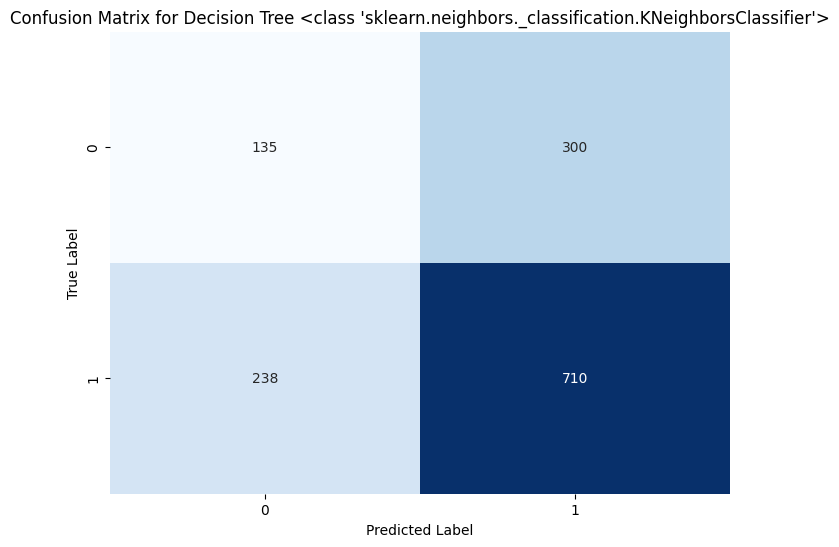

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model=fit_and_evaluate(X_train, y_train,X_test , y_test,KNeighborsClassifier(algorithm='auto', n_neighbors=15, weights='uniform'))


In [12]:
import joblib

# Specify the full path including the filename and .joblib extension
model_path = '/content/drive/MyDrive/GP-Trail/knnWithHayperParameter.joblib'

# Save your model
joblib.dump(model, model_path)

['/content/drive/MyDrive/GP-Trail/knnWithHayperParameter.joblib']

**KNN with DT**

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

def select_features_with_decision_tree(model,X_train, y_train, X_test, y_test, threshold=0.1):
    tree_params = {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5}
    # Train a Decision Tree Classifier
    dt_classifier = DecisionTreeClassifier(**tree_params)

    # Train a Decision Tree classifier to select important features
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train, y_train)

    # Select features based on importance using the trained Decision Tree
    sfm = SelectFromModel(dt, threshold=0.1)
    sfm.fit(X_train, y_train)

    # Transform the training and testing data to include only the selected features
    X_train_selected = sfm.transform(X_train)
    X_test_selected = sfm.transform(X_test)

    print(X_train_selected)
    print(X_test_selected)
    print("-------------------------")
    # Get indices of selected features
    selected_feature_indices = sfm.get_support(indices=True)

    # Get names of selected features
    selected_feature_names = [f"Feature {i+1}" for i in selected_feature_indices]

    # Print selected features
    print("Selected Features:")
    for feature in selected_feature_names:
        print(feature)

    model2=fit_and_evaluate(X_train_selected,y_train,X_test_selected,y_test,model)
    return model2



In [6]:
def fit_and_evaluate(X_train, y_train, X_test, y_test,model):

  model.fit(X_train, y_train)

  # Predictions on the test set
  y_pred = model.predict(X_test)

  # Calculate evaluation metrics
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  f1 = f1_score(y_test, y_pred, average='weighted')


  # Print the results
  print("Accuracy:", accuracy)
  print("Recall:", recall)
  print("Precision:", precision)
  print("F1-score:", f1)


  print("Classification Report (Test):\n", classification_report(y_test, y_pred))

  # Compute the confusion matrix for the test set
  cm_test = confusion_matrix(y_test, y_pred)

  # Plot the confusion matrix for the test set
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title(f"Confusion Matrix for Decision Tree {model.__class__}")
  plt.show()

  return model

[[-3.92122071 -4.19766329 -4.14916175 -4.19766329]
 [-3.92122071 -4.19766329 -4.14916175 -4.19766329]
 [-3.92122071  0.18658284  0.1705135   0.18658284]
 ...
 [-0.17531763 -0.12309218 -0.08673444 -0.15129016]
 [-0.17531763 -0.12309218 -0.08673444 -0.15129016]
 [-0.17531763  8.73954447 -0.08673444 -0.15129016]]
[[-1.47669020e-01 -3.20702906e-13 -1.20165967e-01 -8.46864627e-02]
 [-1.47669020e-01 -3.20702906e-13 -1.20165967e-01 -8.46864627e-02]
 [-1.47669020e-01 -3.20702906e-13 -1.20165967e-01 -8.46864627e-02]
 ...
 [-8.61341994e-02 -1.22234380e-01 -1.95253142e-01 -1.50228465e-01]
 [-8.61341994e-02 -1.22234380e-01 -1.95253142e-01 -1.50228465e-01]
 [-8.61341994e-02 -1.22234380e-01 -1.95253142e-01 -1.50228465e-01]]
-------------------------
Selected Features:
Feature 8217
Feature 20790
Feature 32934
Feature 34749
Accuracy: 0.7744034707158352
Recall: 0.7744034707158352
Precision: 0.7764634856357852
F1-score: 0.7753507741486777
Classification Report (Test):
               precision    recall 

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


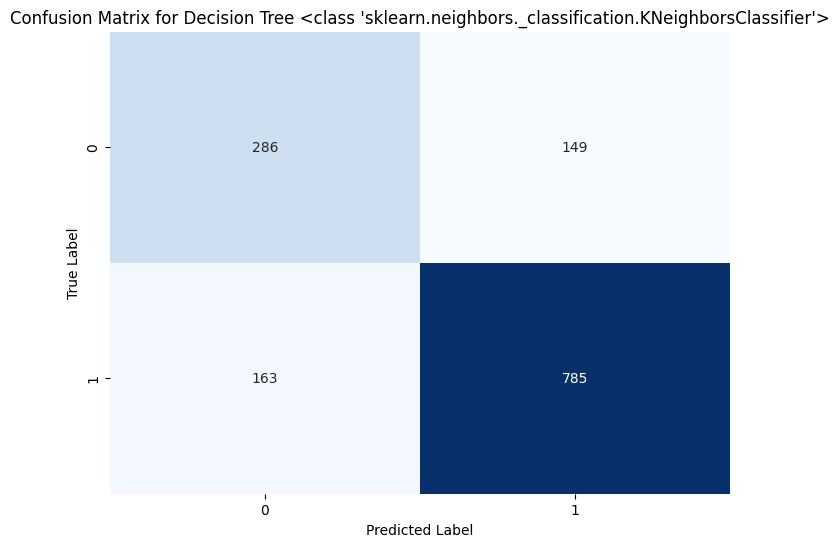

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model=select_features_with_decision_tree(KNeighborsClassifier(algorithm='auto', n_neighbors=15, weights='uniform'),X_train, y_train,X_test , y_test)


In [12]:
import joblib

# Specify the full path including the filename and .joblib extension
model_path = '/content/drive/MyDrive/GP-Trail/knnWithHayperParameter_DT.joblib'

# Save your model
joblib.dump(model, model_path)

['/content/drive/MyDrive/GP-Trail/knnWithHayperParameter_DT.joblib']